# ライブラリ

In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# 制御U素子の実装

## $Z-Y$分解
$U = e^{i\alpha} R_{z}(\beta) R_{y}(\gamma) R_{z}(\delta)$ とした時、
$\left\{\begin{array}{l}
A = R_{z}(\beta) R_{y}\left(\frac{\gamma}{2}\right) \\
B = R_{y}\left(-\frac{\gamma}{2}\right) R_{z}\left(-\frac{\delta - \beta}{2}\right) \\
C = R_{z}\left(\frac{\delta - \beta}{2}\right)
\end{array}\right.$
とすることで、
$\left\{\begin{array}{c}
ABC = \mathbb{I} \\
e^{i\alpha} AXBXC = U
\end{array}\right.$
となることを用いて設計する。

### 例：Hadamard変換

$H = e^{\frac{i\pi}{2}} R_{z}\left(\frac{\pi}{2}\right) R_{y}\left(\frac{\pi}{2}\right) R_{z}\left(\frac{\pi}{2}\right)$
より、
$\left\{\begin{array}{l}
A = R_{z}\left(\frac{\pi}{2}\right) R_{y}\left(\frac{\pi}{4}\right) \\
B = R_{y}\left(-\frac{\pi}{4}\right) R_{z}\left(-\frac{\pi}{2}\right) \\
C = R_{z}\left(0\right)
\end{array}\right.$

In [2]:
qr = QuantumRegister(2, name="qubit")
cr = ClassicalRegister(2, name="measure")
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])  # 初期化
qc.p(np.pi/2, qr[0])  # P
qc.rz(np.pi/2, qr[1])  # A
qc.ry(np.pi/4, qr[1])  # A
qc.cx(qr[0], qr[1])
qc.ry(-np.pi/4, qr[1])  # B
qc.rz(-np.pi/2, qr[1])  # B
qc.cx(qr[0], qr[1])
qc.rz(0, qr[1])  # C
qc.measure(qr, cr[::-1])  # 表示した時左から順に qr[0], qr[1], ...

### 回路図

In [3]:
qc.draw()

┌───┐    ┌────────┐                                           ┌─┐»
  qubit_0: ───┤ H ├────┤ P(π/2) ├──■────────────────────────────■───────────┤M├»
           ┌──┴───┴──┐┌┴────────┤┌─┴─┐┌──────────┐┌──────────┐┌─┴─┐┌───────┐└╥┘»
  qubit_1: ┤ Rz(π/2) ├┤ Ry(π/4) ├┤ X ├┤ Ry(-π/4) ├┤ Rz(-π/2) ├┤ X ├┤ Rz(0) ├─╫─»
           └─────────┘└─────────┘└───┘└──────────┘└──────────┘└───┘└───────┘ ║ »
measure: 2/══════════════════════════════════════════════════════════════════╩═»
                                                                             1 »
«              
«  qubit_0: ───
«           ┌─┐
«  qubit_1: ┤M├
«           └╥┘
«measure: 2/═╩═
«            0

###  実行
$\text{qubit}_{0} = 0$ の時には必ず $\text{qubit}_{1} = 0$ となっている。

一方で、 $\text{qubit}_{0} = 1$ の時には $\text{qubit}_{1} = 0$ と $\text{qubit}_{1} = 1$ の確率が等しくなっている。

すなわち、制御 H 素子が実装できている。

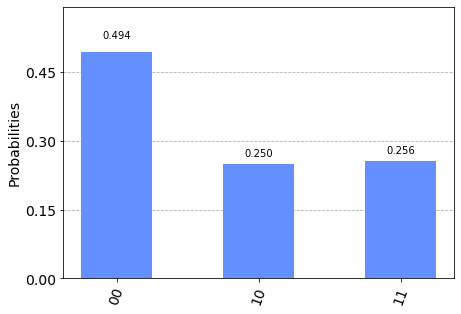

In [4]:
backend = QasmSimulator()
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
plot_histogram(counts)

## Toffoli 素子
Controled SVdgGate が存在しなかったので、 $V = e^{i\frac{\pi}{4}}R_{x}\left(-\frac{\pi}{2}\right)$ を利用

In [5]:
qr = QuantumRegister(3, name="qubit")
cr = ClassicalRegister(3, name="measure")
qc = QuantumCircuit(qr, cr)
qc.h(qr[0:2])  # 初期化
qc.csx(qr[0], qr[2])  # V
qc.csx(qr[1], qr[2])  # V
qc.cx(qr[0], qr[1])
qc.cp(np.pi/4, qr[1], qr[2])  # V^t start
qc.cx(qr[1], qr[2])
qc.cp(np.pi/4, qr[1], qr[2])
qc.cx(qr[1], qr[2])
qc.crx(-np.pi/2, qr[1], qr[2])  # V^t end
qc.cx(qr[0], qr[1])
qc.measure(qr, cr[::-1])  # 表示した時左から順に qr[0], qr[1], ...

### 回路図

In [6]:
qc.draw()

┌───┐                                                              »
  qubit_0: ┤ H ├──■───────────■────────────────────────────────────────────■──»
           ├───┤  │         ┌─┴─┐                                        ┌─┴─┐»
  qubit_1: ┤ H ├──┼─────■───┤ X ├─■─────────■───■─────────■───────■──────┤ X ├»
           └───┘┌─┴──┐┌─┴──┐└───┘ │P(π/4) ┌─┴─┐ │P(π/4) ┌─┴─┐┌────┴─────┐└┬─┬┘»
  qubit_2: ─────┤ Sx ├┤ Sx ├──────■───────┤ X ├─■───────┤ X ├┤ Rx(-π/2) ├─┤M├─»
                └────┘└────┘              └───┘         └───┘└──────────┘ └╥┘ »
measure: 3/════════════════════════════════════════════════════════════════╩══»
                                                                           0  »
«           ┌─┐   
«  qubit_0: ┤M├───
«           └╥┘┌─┐
«  qubit_1: ─╫─┤M├
«            ║ └╥┘
«  qubit_2: ─╫──╫─
«            ║  ║ 
«measure: 3/═╩══╩═
«            2  1

### 実行
$\text{qubit}_{0} = 1 \wedge \text{qubit}_{1} = 1$ の時のみ $\text{qubit}_{2} = 1$ となっている。

すなわち、Toffoli 素子の実装ができている。

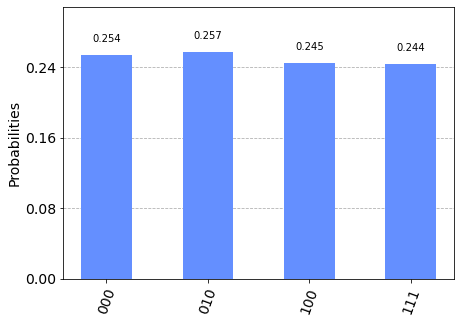

In [7]:
backend = QasmSimulator()
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
plot_histogram(counts)